In [1]:
# -- IMPORTS -- #
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image as kerasImage
from keras.layers import Dense
from keras.models import Model
from keras.activations import relu
from tensorflow.python.framework import ops
from PIL import Image as pilImage
from os import listdir
from os.path import isfile, join
import keras.backend as K
import os
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [26]:
# -- DEFINE FUNCTIONS -- #
def load_image(path,targetSize=(224,224),preprocess=True):
    data = kerasImage.load_img(path,target_size=targetSize)
    if preprocess:
        data = kerasImage.img_to_array(data)
        data = np.expand_dims(data,axis=0)
        data = preprocess_input(data)
    return data

def deprocess_image(x):
    x = x.copy()
    x -= x.mean(); x /= (x.std() + K.epsilon()); x *= 0.1
    # CLIP DATA
    x += 0.5; x = np.clip(x, 0, 1)
    # CONVERT TO RGB
    x *= 255; x = np.clip(x, 0, 255).astype('uint8')
    return x

def configure_guided_backpropagation(model):
    if 'GuidedBackProp' not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * tf.cast(op.inputs[0] > 0., dtype)
    weights = model.layers[-1].get_weights()
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu':'GuidedBackProp'}):
        layerList = [layer for layer in model.layers[1:] if hasattr(layer, 'activation')]
        for layer in layerList:
            if layer.activation == relu:
                layer.activation = tf.nn.relu
        # -- RECALL THE MODEL -- #
        model1 = VGG16(weights='imagenet',include_top=True)
        model1.layers.pop()
        model1.layers[-1].outbound_nodes = []
        model1.outputs = [model1.layers[-1].output]
        output = Dense(1000,activation='relu',name='predictions')(model1.outputs[0])
        guidedModel = Model(inputs=model1.inputs,outputs=[output])
        guidedModel.layers[-1].set_weights(weights)
    return guidedModel

def guided_backpropagation(imgInput, guidedModel, activationLayer, option):
    modelInput = guidedModel.input
    layerOutput = guidedModel.get_layer(activationLayer).output
    # OPTIONS
    if option == 0:
        argument = K.gradients(K.max(layerOutput),modelInput)[0]
    elif option == 1:
        argument = K.gradients(layerOutput,modelInput)[0]  
    else:
        return 'NOT VALID'
    getGraph = K.function([modelInput],[argument])
    saliency = getGraph([imgInput])
    return saliency

In [7]:
# -- CREATE DIRECTORY -- #
if not os.path.isdir('./Results/Guided'):
    os.mkdir('./Results/Guided')

# -- GET LIST OF IMAGES -- #
#reservedFiles = ['.DS_Store']
#dataDirectory = './Data/images/'
#imgTest = []
#for im in listdir(dataDirectory):
#    if isfile(join(dataDirectory, im)) and im not in reservedFiles:
#        imgTest.append(join(dataDirectory,im))  

# -- BUILD MODELS -- #
model = VGG16(weights='imagenet',include_top=True)
guidedModel = configure_guided_backpropagation(model)

Instructions for updating:
Colocations handled automatically by placer.


In [29]:
# -- USER PRIORITIES -- #
gradOption = int(input('Select the type of gradient Max(0) Output(1)'))
#imgSel = int(input('Select an image. From (0-{0})'.format(len(imgTest)-1)))
for layer in guidedModel.layers:
    if hasattr(layer, 'activation'):
        print(layer.name)
layerSel = input('Select the activation Layer:')
imgSel = input('Select the image')
fileName = './Data/images/'+imgSel+'.jpg'

Select the type of gradient Max(0) Output(1) 1


block1_conv1
block1_conv2
block2_conv1
block2_conv2
block3_conv1
block3_conv2
block3_conv3
block4_conv1
block4_conv2
block4_conv3
block5_conv1
block5_conv2
block5_conv3
fc1
fc2
predictions


Select the activation Layer: block5_conv3
Select the image test_56


In [30]:
# -- GUIDED BACK PROPAGATION -- #
img = load_image(fileName)
prediction = model.predict(img)
top = decode_predictions(prediction, top=5)[0]
classes = np.argsort(prediction[0])[-5:][::-1]
print('Model prediction:')
for c, p in zip(classes, top):
    print('\t{:15s}\t({})\twith probability {:.3f}'.format(p[1], c, p[2]))
    
# -- GET SALIENCE MAP -- #
saliency = guided_backpropagation(img,guidedModel,layerSel,gradOption)
salImage = deprocess_image(saliency[0][0,:,:,:].copy())
sal = saliency[0][0,:,:,:].copy()
combined = sal[:,:,0]+sal[:,:,1]+sal[:,:,2]

Model prediction:
	coyote         	(272)	with probability 0.985
	timber_wolf    	(269)	with probability 0.013
	red_wolf       	(271)	with probability 0.001
	grey_fox       	(280)	with probability 0.001
	white_wolf     	(270)	with probability 0.001


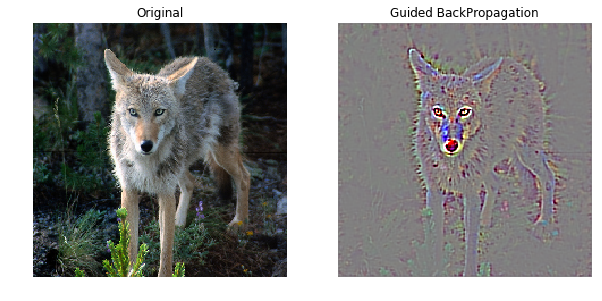

In [31]:
# -- PRESENT IMAGES -- #
saveName = './Results/Guided/'+layerSel+'_'+str(gradOption)+'_'+imgSel+'.png'
fig = plt.figure(figsize=(15, 12))
plt.subplot(131)
plt.title('Original')
plt.axis('off')
plt.imshow(load_image(fileName, preprocess=False))
plt.subplot(132)
plt.title('Guided BackPropagation')
plt.axis('off')
plt.imshow(salImage)
plt.subplot(133)
plt.title('Positive and Negative Influences')
plt.axis('off')
plt.imshow(deprocess_image(combined.copy()),cmap='bwr')
fig.savefig(saveName)

In [8]:
def load_image(path,targetSize=(224,224),preprocess=True):
    data = kerasImage.load_img(path,target_size=targetSize)
    if preprocess:
        data = kerasImage.img_to_array(data)
        data = np.expand_dims(data,axis=0)
        data = preprocess_input(data)
    return data

def deprocess_image(x):
    x = x.copy()
    x -= x.mean(); x /= (x.std() + K.epsilon()); x *= 0.1
    # CLIP DATA
    x += 0.5; x = np.clip(x, 0, 1)
    # CONVERT TO RGB
    x *= 255; x = np.clip(x, 0, 255).astype('uint8')
    return x

def configure_guided_backpropagation(model,fileName):
    imgInput = load_image(fileName)
    if 'GuidedBackProp' not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * tf.cast(op.inputs[0] > 0., dtype)
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu':'GuidedBackProp'}):
        layerList = [layer for layer in model.layers[1:] if hasattr(layer, 'activation')]
        for layer in layerList:
            if layer.activation == relu:
                layer.activation = tf.nn.relu
        # -- RECALL THE MODEL -- #
        guidedModel = VGG16(weights='imagenet',include_top=True)
        modelInput = guidedModel.input
        layerOutput = guidedModel.get_layer('block5_conv3').output
        argument = K.gradients(layerOutput,modelInput)[0]  
        getGraph = K.function([modelInput],[argument])
        saliency = getGraph([imgInput])
        sal = saliency[0][0,:,:,:].copy()
        combined = sal[:,:,0]+sal[:,:,1]+sal[:,:,2]
        fig = plt.figure(figsize=(10, 8))
        plt.subplot(121)
        plt.title('Guided BackPropagation')
        plt.axis('off')
        plt.imshow(deprocess_image(saliency[0][0,:,:,:].copy()))
        plt.subplot(122)
        plt.title('Influences')
        plt.axis('off')
        plt.imshow(deprocess_image(combined.copy()),cmap='bwr')
        plt.show()
        
def configure_normal_backpropagation(model,fileName):
    imgInput = load_image(fileName)
    modelInput = model.input
    layerOutput = model.get_layer('block5_conv3').output
    argument = K.gradients(layerOutput,modelInput)[0]  
    getGraph = K.function([modelInput],[argument])
    saliency = getGraph([imgInput])
    sal = saliency[0][0,:,:,:].copy()
    combined = sal[:,:,0]+sal[:,:,1]+sal[:,:,2]
    fig = plt.figure(figsize=(10, 8))
    plt.subplot(121)
    plt.title('Normal BackPropagation')
    plt.axis('off')
    plt.imshow(deprocess_image(saliency[0][0,:,:,:].copy()))
    plt.subplot(122)
    plt.title('Influences')
    plt.axis('off')
    plt.imshow(deprocess_image(combined.copy()),cmap='bwr')
    plt.show()

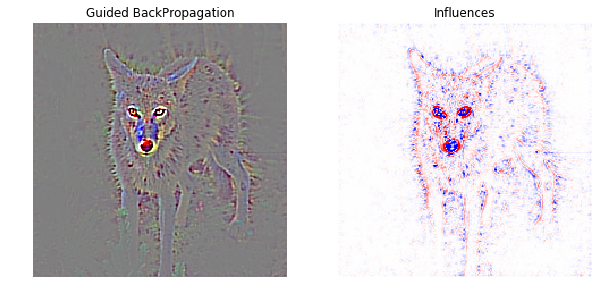

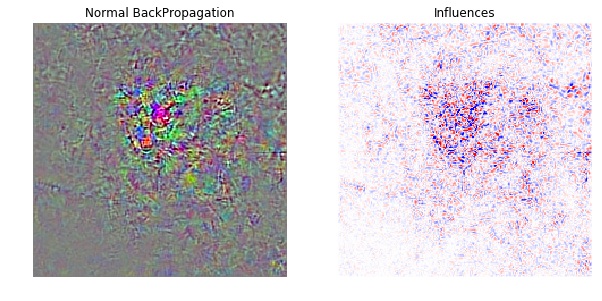

In [9]:
model = VGG16(weights='imagenet',include_top=True)
configure_guided_backpropagation(model,'./Data/images/test_56.jpg')
configure_normal_backpropagation(model,'./Data/images/test_56.jpg')